# Яндекс.Афиша

In [1]:
# подгружаем библиотеки и изучаем таблицы
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv') 
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
# Посмотрим, что у нас есть в данных
print(visits.head())
visits.info()

                    Uid   Device            End Ts  Source Id  \
0  16879256277535980062    touch  20.12.2017 17:38          4   
1    104060357244891740  desktop  19.02.2018 17:21          2   
2   7459035603376831527    touch   01.07.2017 1:54          5   
3  16174680259334210214  desktop  20.05.2018 11:23          9   
4   9969694820036681168  desktop  27.12.2017 14:06          3   

           Start Ts  
0  20.12.2017 17:20  
1  19.02.2018 16:53  
2   01.07.2017 1:54  
3  20.05.2018 10:59  
4  27.12.2017 14:06  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
print(orders.head())
orders.info()

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
print(costs.head())
costs.info()

   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
# C данными в этот раз, все даже очень хорошо, единственное, пробелы в наименование колонок и разный регистр - раздражает.
# Что подозрительно это стоимости за сессию. очень уж непонятные единицы. Буду руководстоваться тем, что выгрузили заказчики
# так как уточнить не у кого, тем более что в этом проекте на сколько я понимаю цифры относительны.

visits.columns = ['uid','device','end_ts','source_id', 'start_ts']
orders.columns = ['buy_ts','revenue','uid']

# Добавим дополнительные столбцы разбивающие дату на части а дату и время приведем к одному типу 

visits['end_ts'] = visits['end_ts'] + str(':00')
visits['start_ts'] = visits['start_ts'] + str(':00')

visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%d.%m.%Y %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%d.%m.%Y %H:%M:%S')

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d %H:%M:%S')

## Исселедование по поставленным вопросам

# Продукты

* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?


In [7]:
#Сколько людей пользуются в день, неделю, месяц?

#Необходимо добавить к датасету необходимые столбцы, чтобы расчитать данные показатели

visits['use_month'] = visits['start_ts'].astype('datetime64[M]')
visits['use_week'] = visits['start_ts'].astype('datetime64[W]')
visits['use_day'] = visits['start_ts'].astype('datetime64[D]')

In [8]:
# напишим функцию которой будем подавать период и забирать среднее количество человек
# Количество сессий за за период очень эластичный показатель с множетвом переменных как выходные, праздники, неделя моды...
# по этому на мой взляд лучше взять среднюю а не медиану
def how_much_users_use_resurs_mean(time):
    users_count = visits.groupby(time).agg({'uid': 'nunique'})
    return users_count['uid'].mean()

In [9]:
use_day = how_much_users_use_resurs_mean('use_day')
use_week = how_much_users_use_resurs_mean('use_week')
use_month = how_much_users_use_resurs_mean('use_month')

print(f'В среденем в день пользуются {int(use_day)} людей')
print(f'В среденем в неделю пользуются {int(use_week)} людей')
print(f'В среденем в месяц пользуются {int(use_month)} людей')

В среденем в день пользуются 907 людей
В среденем в неделю пользуются 5724 людей
В среденем в месяц пользуются 23228 людей


In [10]:
# Сколько сессий в день?

# так же берем среднюю по дням
sessions_day = visits.groupby(['use_day'])[['uid']].count()
mean_session_day = int(sessions_day['uid'].mean())
print(f'В среднем сессий {mean_session_day} подключения за день')

В среднем сессий 984 подключения за день


In [11]:
# Сколько длится одна сессия?

visits['time_delta_session'] = visits['end_ts'] - visits['start_ts']
one_session_continue = visits['time_delta_session'].mean()

x = str(one_session_continue).replace('0 days','')
print(f'В среднем длится {x} одна сессия')

В среднем длится  00:10:44.536443 одна сессия


In [12]:
# Как часто люди возвращаются?
# Рассчитаем Retention Rate в пределах месяцев так как данные почти за 2 года

# узнаем первый заход в программу
first_activity_date = visits.groupby(['uid'])['use_day'].min()
first_activity_date.name = 'first_activity_date'
visits_for_cagort = visits.join(first_activity_date,on='uid')

In [13]:
# вычислим первый месяц активности пользоателя и привидем все активности в "месячный" период

visits_for_cagort['first_activity_month'] = visits_for_cagort['first_activity_date'].astype('datetime64[M]')
visits_for_cagort['activity_month'] = visits_for_cagort['use_month'].astype('datetime64[M]')

In [14]:
# Разделим пользвоателей по кагортам в соотвествие с первой активностью в приложение "Янгдекс.АФиша"

visits_for_cagort['cohort_lifetime'] = visits_for_cagort['activity_month'] - visits_for_cagort['first_activity_month']
visits_for_cagort['cohort_lifetime'] = visits_for_cagort['cohort_lifetime'] / np.timedelta64(1,'M')
visits_for_cagort['cohort_lifetime'] = visits_for_cagort['cohort_lifetime'].astype(int)

In [15]:
# Собирем нужный нам датасет с количеством пользовователей за период в рамках кагорт

cohorts = visits_for_cagort.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [16]:
# Инициализируем таблицу с только с первой активностию

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [17]:
# переименуем столбики таблицы для соединения
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})

In [18]:
# Соединим таблицы
cohorts = cohorts.merge(inital_users_count,on='first_activity_month')

In [19]:
# расчитаем Коилчество пользоватлей которые возвращались в рамках кагорты
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [20]:
# Собирем таблицу которая удовлетворяет данным для построения темлового графика

retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',
                                                                      values='retention',aggfunc='sum')

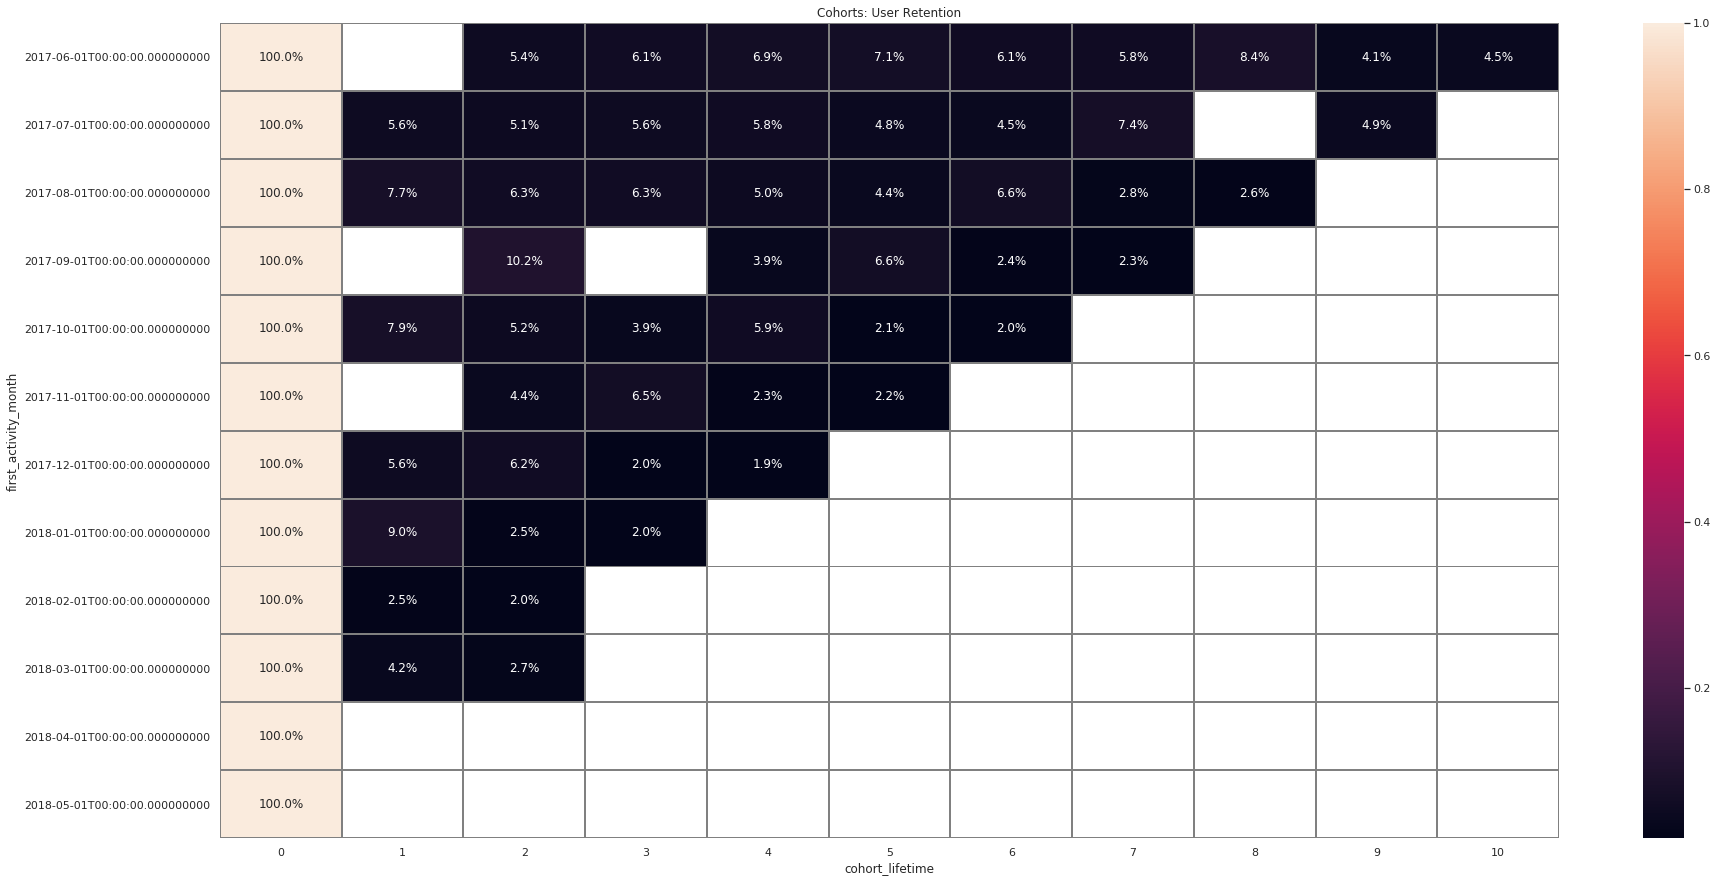

In [21]:
sns.set(style='white')
plt.figure(figsize=(30, 15))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

### Вывод по таблицу с активностю пользователей

* В среденем в день пользуются 907 людей
* В среденем в неделю пользуются 5724 людей
* В среденем в месяц пользуются 23228 людей

* В среднем сессий 984 подключения за день

* В среднем длится  00:10:44.536443 одна сессия

#### Ratation rate
    
Индекс возврата пользователей после первой покупке готоворит нам о том, что маркетингу есть над чем работать. Видим, что дела у сервиса обстоят вяло. Опустим тот факт, что каждая кагорта страртует с невыдающихся показателей но и прирост в течение времени совсем не заметен. Все люди после первой недели пользуются сервисом примерно на одном минимальном уровне.

# Продажи

* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

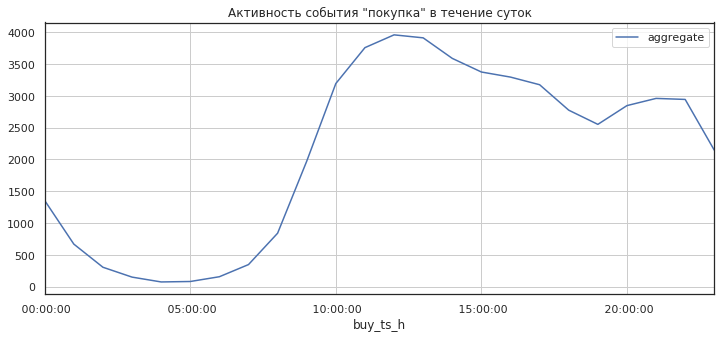

In [22]:
# Когда люди начинают покупать?
# провакационный вопос. Я его трактую так: в какой части дня пользователи совершают больше всего покупок
# Для этого собираюсь вычленить "час" из даты и построить гистрограму 
# которая хорошо покажет в какой час будет больше всего покупок

orders['buy_ts_h'] = orders['buy_ts'].astype('datetime64[h]')
orders['buy_ts_h'] = orders['buy_ts_h'].astype('str')
orders['buy_ts_h'] = orders['buy_ts_h'].apply(lambda x: str(x)[-9:])
orders['aggregate'] = 1

df_hist = orders.pivot_table(index = 'buy_ts_h', values=['aggregate'], aggfunc='sum')

title_n = 'Активность события "покупка" в течение суток'
df_hist.plot(grid=True, figsize=(12, 5), title = title_n);

Активность пользователей имеет свой пик в полдень и плавно снижается к семи часам а потом опять немного растет. Очень интересный и показательный график. Люди чаще всего привыкли брать билеты на мероприятия в тот же день когда оно начинается и тут мы видим, что уторм идет покупка билетов на вечер. И так как мероприятия чаще всего начинаются в 19.00 мы видим небольшой всплеск перед этим временем, а потом опять спад. Ночью мы скорее всего видим только покупки билетов в кино.

In [23]:
# Сколько раз покупают за период?
buy_period = orders.groupby(['buy_ts']).agg({'uid':'nunique'}).reset_index()
buy_period['buy_day'] = buy_period['buy_ts'].astype('datetime64[D]')
buy_period['buy_week'] = buy_period['buy_ts'].astype('datetime64[W]')
buy_period['buy_mount'] = buy_period['buy_ts'].astype('datetime64[M]')
buy_period['buy_year'] = buy_period['buy_ts'].astype('datetime64[Y]')

In [24]:
def plot_of_period(period, title_n):
    
    df_hist = buy_period.pivot_table(index = period, values=['uid'], aggfunc='sum')
    df_hist.plot(grid=True, figsize=(12, 5), title = title_n);

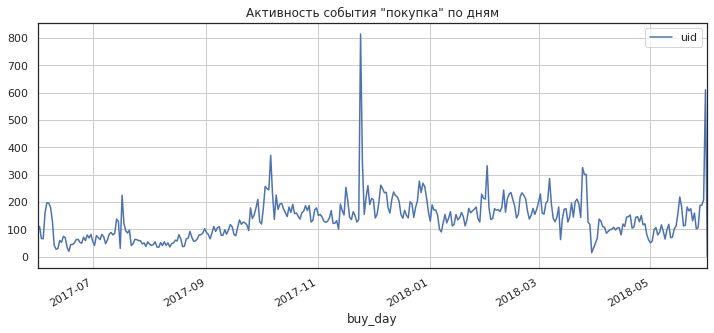

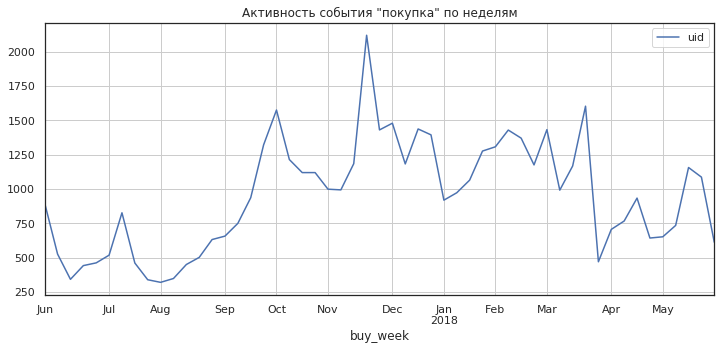

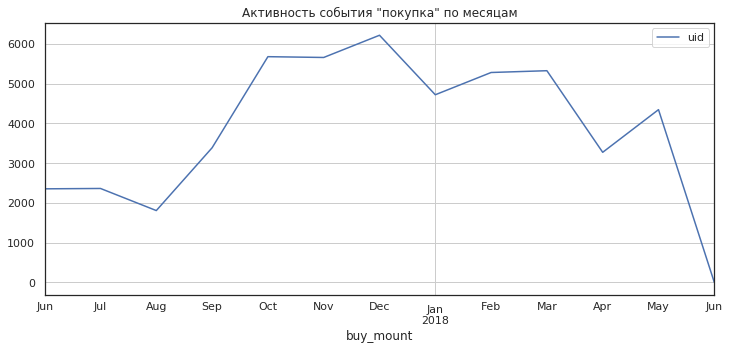

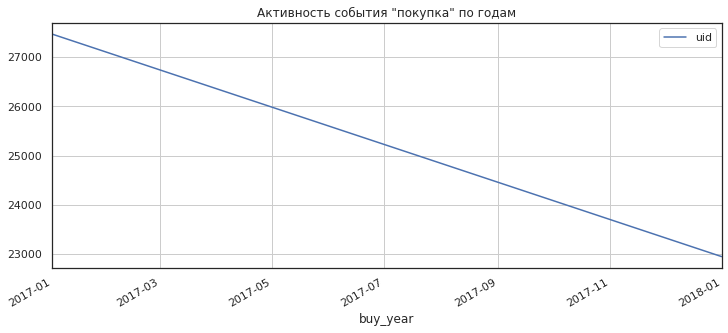

In [25]:
plot_of_period('buy_day', 'Активность события "покупка" по дням')
plot_of_period('buy_week', 'Активность события "покупка" по неделям')
plot_of_period('buy_mount', 'Активность события "покупка" по месяцам')
plot_of_period('buy_year', 'Активность события "покупка" по годам')

По данным графикам видна одна пересакающая их все идея - покупки в приложение идут на спад. Пиковые нагрузки по дням мы видим перед новым годом и снимжающаяся прямая после нового года влоть до конца лета. Я бы это охарактеризовал погодой в России. Самые пики по продажам билетов приходятся на зимний период когда очень сложно просто проводить долго времени на улице. 

In [26]:
# Какой средний чек?
mean_receipt = orders['revenue'].mean()
print(f'Средний чек составляет {mean_receipt:.2f}')

Средний чек составляет 5.00


In [27]:
# Сколько денег приносят? (LTV)

# Рассмотрим, что есть в датасете
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [28]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [29]:
# Добавим колонки для расчетов в нужном нам типе

orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

In [30]:
# Собирем датасет с количеством пользователей и покупок от "первого периода"

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Проверим данные
print(first_orders.head())

                uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


In [31]:
# Размеры кагорт в зависимости от количества пользователей от первого прихода
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# Объединим таблицы с выручкой по пользваотелям
orders_new = pd.merge(orders,first_orders, on='uid')

# Сгруппируем таблицу
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

In [32]:
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [33]:
# Соединим таблицу с показателями и размерами кагорт
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

# Оговоренная маржа 100%
margin_rate = 1
    
# добавляем столбцы нужными нам показателями    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [34]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724,0.485,0.438,0.955,1.023,0.736,0.95,0.582,0.553,0.606,0.571,0.257
2017-07-01,6.010,0.335,0.624,0.359,0.177,0.156,0.12,0.142,0.161,0.147,0.156,
2017-08-01,5.277,0.472,0.458,0.391,0.494,0.284,0.211,0.405,0.292,0.188,,
2017-09-01,5.645,1.118,0.521,3.976,0.401,0.647,0.702,0.243,0.184,,,
2017-10-01,5.004,0.536,0.191,0.157,0.152,0.12,0.085,0.115,,,,
2017-11-01,5.155,0.399,0.2,0.325,0.148,0.054,0.115,,,,,
2017-12-01,4.738,0.26,0.925,1.065,0.313,0.338,,,,,,
2018-01-01,4.136,0.295,0.304,0.143,0.063,,,,,,,
2018-02-01,4.157,0.278,0.079,0.074,,,,,,,,


In [35]:
ltv_20170601 = output.loc['2017-06-01'].sum()
print(ltv_20170601)

11.88


In [36]:
def cac_ltv_mounth(date_cogort, number_buyer, title):

    # отфильруем нужную когорту
    cohort_201706 = report[report['first_order_month'] == date_cogort]

    # посчитаем расходы за этот месяц
    costs_201706 = costs[costs['month'] == date_cogort]['costs'].sum()

    n_buyers_201706 = cohort_201706['n_buyers'][number_buyer]
    cac_201706 = costs_201706 / n_buyers_201706
    ltv_201706   = output.loc[date_cogort].sum()

    print(title)
    print('CAC =', cac_201706)
    print('LTV =', ltv_201706)

In [37]:
cac_ltv_mounth('2017-06-01', 0, 'Соотношение доходов к расходам по привлечению кагорты номер 1')
cac_ltv_mounth('2017-09-01', 33, 'Соотношение доходов к расходам по привлечению кагорты номер 4')
cac_ltv_mounth('2017-12-01', 57, 'Соотношение доходов к расходам по привлечению кагорты номер 7')

Соотношение доходов к расходам по привлечению кагорты номер 1
CAC = 8.905091448344043
LTV = 11.88
Соотношение доходов к расходам по привлечению кагорты номер 4
CAC = 9.441654397520342
LTV = 13.437
Соотношение доходов к расходам по привлечению кагорты номер 7
CAC = 8.74180926306183
LTV = 7.639


<span style="color:green"> Привлечение одного покупателя в среднем обходится в 9 единиц, когда прибыль в среднем на человека за пол года в среднем составляем 10 единиц. У нашего проекта всё не так плохо, вложения окупаютс и даже приносят прибыль. Если тенденция будет похожа как в разнице между 1 и 4 когортой то можно точно сказать, что тренд на повышение.  </span>

<span style="color:green">Вообще я всё перепроверил и не вижу никаких ошибок по сравнению с примером который был дан в спринте. Единственный параметр который мне не досутпен это маржа с продажи, за который я беру 0.5 или 50 процентов, что наверное не является правдой. 50 процентов это слишком большая маржа для продажи билетов стороних мероприятий, но все же. 
Еще я дополнил пример сравнением стоимости привлечения клиента(сас) и итоговой суммой денег, которую один клиент приносит в среднем со всех своих покупок(ltv) по кагортам и вывод из этих данных получается не утишительный на 9 единиц вложения 3 единицы прибыли с клиента.</span>

<span style="color:green">  </span>

In [38]:
# Код наставника
report_cum = report.pivot_table(
            index='first_order_month', 
            columns='age', 
            values='ltv', 
            aggfunc='sum').cumsum(axis=1)

report_cum.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


Пердставлен суммарный кумулятивный доход по когортам для одного пользователя. Дальнейшую экономику пользователя буду считать по средней.

In [39]:
# Код наставника
report_cum_per_mounth = report.pivot_table(
                        index='first_order_month', 
                        columns='age', 
                        values='ltv', 
                        aggfunc='sum').cumsum(axis=1)[5].sum()
report_cum_per_mounth

55.78336841145135

In [40]:
monthly_costs = costs.groupby('month').sum()

In [41]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [42]:
cogort_use = costs.groupby(['source_id', 'month']).sum()
cogort_use.reset_index()
cogort_use.head()

costs
source_id month              
1         2017-06-01  1125.61
          2017-07-01  1072.88
          2017-08-01   951.81
          2017-09-01  1502.01
          2017-10-01  2315.75

In [43]:
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [44]:
output_tb = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(3)

output_tb.cumsum(axis=1).round(2)
output_tb.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.531,0.585,0.634,0.741,0.856,0.939,1.046,1.111,1.173,1.241,1.305,1.334
2017-07-01,0.634,0.669,0.735,0.773,0.791,0.808,0.82,0.835,0.852,0.868,0.884,
2017-08-01,0.489,0.532,0.575,0.611,0.657,0.683,0.703,0.74,0.767,0.785,,
2017-09-01,0.598,0.716,0.771,1.192,1.235,1.303,1.378,1.403,1.423,,,
2017-10-01,0.598,0.662,0.685,0.704,0.722,0.736,0.746,0.76,,,,
2017-11-01,0.555,0.598,0.619,0.654,0.67,0.676,0.688,,,,,
2017-12-01,0.542,0.572,0.678,0.799,0.835,0.874,,,,,,
2018-01-01,0.416,0.446,0.476,0.491,0.497,,,,,,,
2018-02-01,0.464,0.495,0.504,0.512,,,,,,,,


In [45]:
output.cumsum(axis=1).mean(axis=0)

age
0      4.801846
1      5.395818
2      5.822000
3      6.689889
4      7.299000
5      7.969429
6      8.388333
7      9.084200
8     10.062750
9      9.251667
10    10.005000
11    11.880000
dtype: float64

### Вывод по данным продаж

Средний чек составляет 5.00

Продажи билетов возрастают в зимний период и падают летом. В течение дня больше всего билетов берут в районе 12.00 дня дальше идет спад и небольшой прирост в районе 18:00 прямо перед основными временем начала мерорпитий в городе. 

<span style="color:green"> Один средне статистический пользователь с начала действия данных принес почти 12 единиц дохода. Расходы на привлечение 1 пользователь окупает примерно на 7ой месяц.</span>

# Маркетинг

* Сколько денег потратили? Всего / на каждый источник / по времени
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы? (ROI)

In [46]:
visits.head()

,uid,device,end_ts,source_id,start_ts,use_month,use_week,use_day,time_delta_session
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-01,2017-12-14,2017-12-20,00:18:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-01,2018-02-15,2018-02-19,00:28:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017-06-29,2017-07-01,00:00:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-01,2018-05-17,2018-05-20,00:24:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-01,2017-12-21,2017-12-27,00:00:00


In [47]:
orders.head()

,buy_ts,revenue,uid,buy_ts_h,aggregate,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,00:00:00,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,00:00:00,1,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,00:00:00,1,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,00:00:00,1,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,07:00:00,1,2017-06-01


In [48]:
# Для того чтобы разбить по платформам создадим два датасета подходящих для склейки
user_desktop = visits[['uid','device', 'use_month', 'use_day', 'source_id']].query('device == "desktop"')
user_touch = visits[['uid','device', 'use_month', 'use_day', 'source_id']].query('device == "touch"')

In [49]:
# Чимленыне показатели стоимостей и прибылей будем клеит в сумме дня и количества пользвателей
# Для этого создадим нужные нам типы новый столбцов
orders['use_day'] = orders['buy_ts'].astype('datetime64[D]')

In [50]:
# Переименуем столбцы для merge
orders.columns = ['buy_ts', 'revenue', 'uid', 'buy_ts_h', 'aggregate', 'use_month', 'use_day']

In [51]:
# Приведем таблицу к дневным показателям 
orders_gr = orders.pivot_table(index = ['uid','use_month','use_day'], values=['revenue'], aggfunc='sum').reset_index()

In [52]:
# Соединим таблицу по заходом на сервис и покупок на нем
user_desktop =  user_desktop.merge(orders_gr, how='left' , on=['uid', 'use_month', 'use_day'])
user_touch =  user_touch.merge(orders_gr,  how='left' ,on=['uid', 'use_month', 'use_day'])

In [53]:
# Уберем нули так как чаще всего билеты брали не каждый день
user_desktop['revenue'] = user_desktop['revenue'].fillna(0)
user_touch['revenue'] = user_touch['revenue'].fillna(0)

In [54]:
# в итоге у нас два датасета для двух платформ: персональная и мобильная
user_desktop = user_desktop.groupby(['source_id','use_day','use_month']).agg({'uid': 'nunique', 'revenue': sum}).reset_index()
user_touch = user_touch.groupby(['source_id','use_day','use_month']).agg({'uid': 'nunique', 'revenue': sum}).reset_index()

In [55]:
costs.columns = ['source_id', 'use_day', 'costs', 'use_month']

In [56]:
user_desktop_cost =  user_desktop.merge(costs,on=['source_id', 'use_day', 'use_month'])
user_touch_cost =  user_touch.merge(costs,on=['source_id', 'use_day', 'use_month'])

In [57]:
# Два готовых датасета с "костами и прибылями" в разрезе плтатформ
user_desktop_cost['costs'] = user_desktop_cost['costs'].fillna(0)
user_touch_cost['costs'] = user_touch_cost['costs'].fillna(0)

In [58]:
print(orders['revenue'].sum())
print(costs['costs'].sum())

252057.19999999998
329131.62


In [59]:
#Сколько денег потратили? Всего / на каждый источник / по времени

# Данные по всем показателям. Это же интересно в сколько же нам вообщем обходится этот сервис.
sum_costs = costs['costs'].sum()
print(f'Всего на маркетинг было потрачено {sum_costs}')

sum_user_desktop_cost = user_desktop_cost['costs'].sum()
print(f'Всего на маркетинг было потрачено {sum_user_desktop_cost} для версии десктоп')

sum_user_touch_cost = user_touch_cost['costs'].sum()
print(f'Всего на маркетинг было потрачено {sum_user_touch_cost.round(3)} для версии мобильных платформ')

Всего на маркетинг было потрачено 329131.62
Всего на маркетинг было потрачено 329126.59 для версии десктоп
Всего на маркетинг было потрачено 328788.83 для версии мобильных платформ


In [60]:
# Временно (Наставник)
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

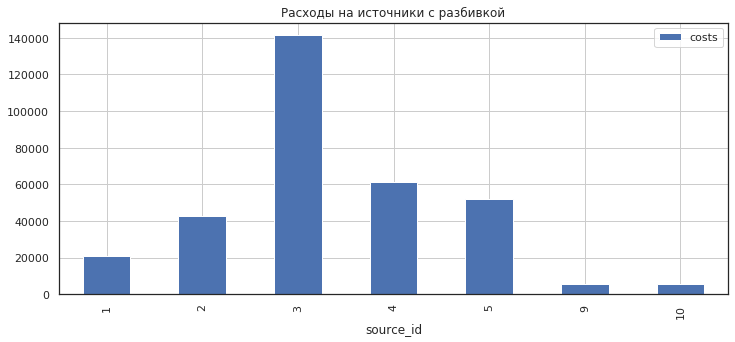

In [61]:
# Расходы на источники для всего датасета
df_costs = costs.pivot_table(index = 'source_id', values=['costs'], aggfunc='sum')
title_n = 'Расходы на источники с разбивкой'
df_costs.plot(kind='bar', grid=True, figsize=(12, 5), title = title_n);

Лидер по расходам, источник номер 3 c показателем 140000 за 2 года
    * второе место у источника номер 4 с показателем 60000
    * третье - 5 (5100)
    * четвертое - 2 (4200)

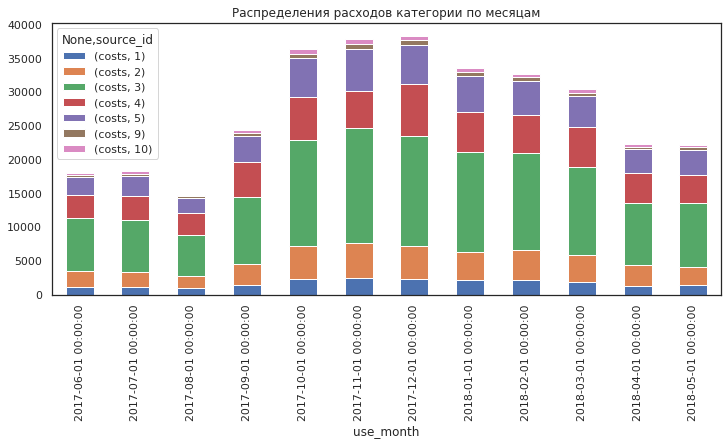

In [62]:
# так как у нас данные почти за 2 года возьмем суммуу помесячно
df_costs = costs.pivot_table(index = 'use_month',columns = 'source_id', values=['costs'], aggfunc='sum')
title_n = 'Распределения расходов категории по месяцам'
df_costs.plot(kind='bar', stacked = True,  figsize=(12, 5), title = title_n);

Тут конечно вопрос интересный. Я написал, что количество продажи билетов зависит от времени года и погоды на улице, но из этого графика видно, что рост продаж в эти месяцы еще подхватывает отдел маркетинга, который активизируется именно в эти месяцы.

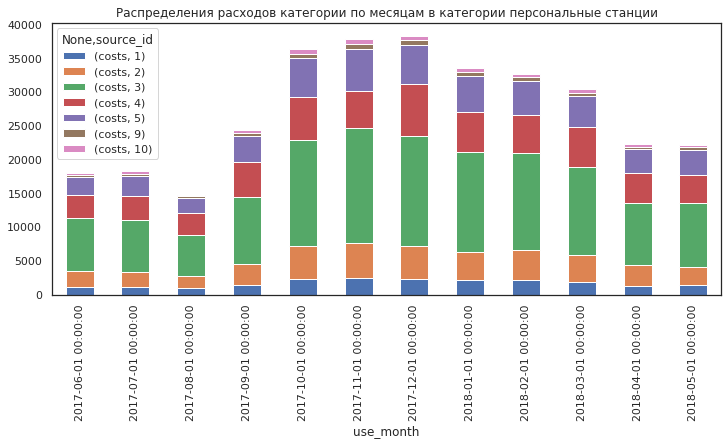

In [63]:
# так как у нас данные почти за 2 года возьмем суммуу помесячно
df_costs_desk = user_desktop_cost.pivot_table(index = 'use_month',columns = 'source_id', values=['costs'], aggfunc='sum')
title_n = 'Распределения расходов категории по месяцам в категории персональные станции'
df_costs_desk.plot(kind='bar', stacked = True,  figsize=(12, 5), title = title_n);

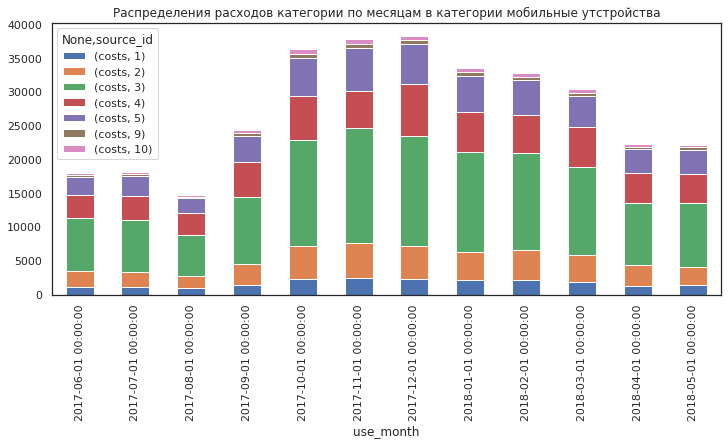

In [64]:
# так как у нас данные почти за 2 года возьмем суммуу помесячно
df_costs_touch = user_touch_cost.pivot_table(index = 'use_month',columns = 'source_id', values=['costs'], aggfunc='sum')
title_n = 'Распределения расходов категории по месяцам в категории мобильные утстройства'
df_costs_touch.plot(kind='bar', stacked = True,  figsize=(12, 5), title = title_n);

Сильной разницы в тратах по платформам из этого графика не видно. У нас в виде методов только цифры, я так подозреваю, что эти источники рекламы балготворно влияют как на мобильную так и на персональную версию платыформы.

In [65]:
# Сколько стоило привлечение одного покупателя из каждого источника?

# Узнаем стоимость для всего датасета

# Сгруппируем покупателей по источникам и узнаем их количество
user_advertise = visits.groupby(['source_id']).agg({'uid': 'nunique'}).reset_index()
# 
type_advertise = costs.groupby(['source_id'])[['costs']].sum().reset_index()
full_tabl_advertise =  user_advertise.merge(type_advertise,on='source_id')

full_tabl_advertise.columns = ['source_id','count_users','costs']
full_tabl_advertise['price_per_user'] = full_tabl_advertise['costs']/full_tabl_advertise['count_users']
full_tabl_advertise.reset_index()
full_tabl_advertise

,source_id,count_users,costs,price_per_user
0,1,18999,20833.27,1.096546
1,2,26245,42806.04,1.631017
2,3,74756,141321.63,1.890439
3,4,83525,61073.60,0.731201
4,5,56974,51757.10,0.908434
5,9,9264,5517.49,0.595584
6,10,8067,5822.49,0.721766


In [66]:
# Узнаем стоимость для пользователей Десктопной версией
per_user_desktop = user_desktop_cost.groupby(['source_id'])[['costs','uid']].sum().reset_index()
per_user_desktop['price_per_user'] = per_user_desktop['costs']/per_user_desktop['uid']
per_user_desktop.reset_index()
per_user_desktop

,source_id,costs,uid,price_per_user
0,1,20833.27,21789,0.956137
1,2,42806.04,32560,1.314682
2,3,141321.63,64958,2.175585
3,4,61073.60,66504,0.918345
4,5,51756.40,47504,1.089517
5,9,5513.16,9987,0.552034
6,10,5822.49,6880,0.846292


In [67]:
# Узнаем стоимость для пользователей на мобильных устройствах
per_user_touch = user_touch_cost.groupby(['source_id'])[['costs','uid']].sum().reset_index()
per_user_touch['price_per_user'] = per_user_touch['costs']/per_user_touch['uid']
per_user_touch.reset_index()
per_user_touch

,source_id,costs,uid,price_per_user
0,1,20810.19,7586,2.743236
1,2,42806.04,11347,3.772454
2,3,141321.63,19673,7.183532
3,4,61073.60,33594,1.817991
4,5,51756.40,16291,3.176993
5,9,5312.45,3121,1.702163
6,10,5708.52,2581,2.211747


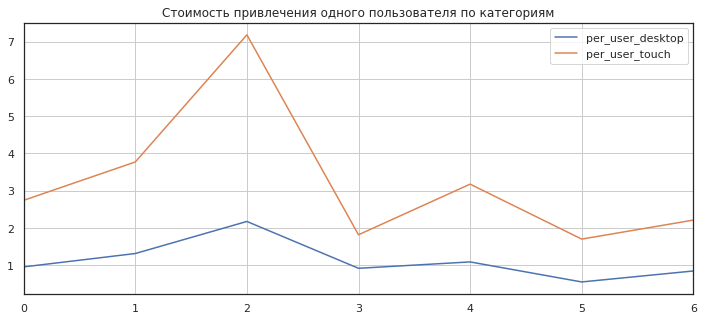

In [68]:
# резюмируем таблички графиком на кокой платформе будет больше всего затрат в рамках одного юзера
full_tabl_per_user  = per_user_desktop.merge(per_user_touch,on=['source_id'])
full_tabl_per_user = full_tabl_per_user[['source_id','price_per_user_x','price_per_user_y']]
full_tabl_per_user.columns = ['source_id', 'per_user_desktop','per_user_touch']
full_tabl_per_user

title_n = 'Стоимость привлечения одного пользователя по категориям'
full_tabl_per_user[['per_user_desktop','per_user_touch']].plot(grid=True, figsize=(12, 5), title = title_n);

Средний чек от одного пользователя 5.0, LTV ~ 10.0, а привлечения одного юзера 7.0. 

<span style="color:green"> Тут можно сказать, так как формула привлечения все косты разделить на количество пользователей. То для этого графика есть такая погрешность, что пользователей на десктоп больше примерно в 2 раза. И так как мы делим на все косты без понимая можно ли разделить эти источники маркетинга по воздействию на платформы. И как за оксиому берем, что все источники хорошо влияют на пользовтелей платформы desktop и touch. Из этого графика следует, что из за того что привлечение второй платфомры намного меньше то и цена пользователя для этой платформы больше. без дополнительного понимания это все, что можно сказать по этому графику </span>

In [69]:
# На сколько окупились расходы? (ROI)
# ROI = (Доход от вложений — Размер вложений) / Размер вложений х 100%

ROI_all = (orders['revenue'].sum() / costs['costs'].sum()) / costs['costs'].sum() * 100
ROI_touch = (user_touch_cost['revenue'].sum() / user_touch_cost['costs'].sum()) / user_touch_cost['costs'].sum() * 100
ROI_desktop = (user_desktop_cost['revenue'].sum() / user_desktop_cost['costs'].sum()) / user_desktop_cost['costs'].sum() * 100

print(f'ROI Для всего датасета {ROI_all}')
print(f'ROI Для платформы мобильных устройств {ROI_touch}')
print(f'ROI Для для платформы десктоп {ROI_desktop}')

ROI Для всего датасета 0.0002326804487712207
ROI Для платформы мобильных устройств 3.6806789080599404e-05
ROI Для для платформы десктоп 0.00022397514922707095


## ROI

In [70]:
first_orders = orders.groupby(['uid']).agg({'use_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [71]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [72]:
visits_day = visits[['uid','device','source_id','use_month','use_day']]

In [73]:
orders_new = pd.merge(orders,first_orders, on='uid')

In [74]:
visits_orders = pd.merge(visits_day,orders_new, on=['uid','use_day','use_month'])
#visits_orders.head()
#orders_new.head()

In [75]:
cohort_sizes = visits_orders.groupby(['first_order_month','source_id','device']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','source_id','device', 'n_buyers']
#cohort_sizes.head(10)

In [76]:
cohorts = visits_orders.groupby(['first_order_month','use_month','source_id','device']).agg({'revenue': 'sum'}).reset_index()
#cohorts.head()

In [77]:
costs_merg = costs.groupby(['source_id','use_month']).agg({'costs': 'sum'}).reset_index()

cohorts_all = cohorts.groupby(['first_order_month','use_month']).agg({'revenue': 'sum'}).reset_index()

cohorts_with_costs = cohorts.merge(costs_merg, how='left' , on=['source_id', 'use_month'])
#cohorts_with_costs.head()

In [78]:
report_roi = pd.merge(cohort_sizes, cohorts_with_costs, on=['first_order_month','source_id','device'])

margin_rate = 1

report_roi['gp'] = report_roi['revenue'] * margin_rate
report_roi['age'] = (report_roi['use_month'] - report_roi['first_order_month']) / np.timedelta64(1, 'M')
report_roi['age'] = report_roi['age'].round().astype('int')

#report_roi['ltv'] = report_roi['gp'] / report_roi['n_buyers']
#report_roi['roi'] = (report_roi['gp']-report_roi['costs']) / report_roi['costs'] * 100

report_roi.head()

,first_order_month,source_id,device,n_buyers,use_month,revenue,costs,gp,age
0,2017-06-01,1,desktop,277,2017-06-01,2024.37,1125.61,2024.37,0
1,2017-06-01,1,desktop,277,2017-07-01,216.62,1072.88,216.62,1
2,2017-06-01,1,desktop,277,2017-08-01,193.82,951.81,193.82,2
3,2017-06-01,1,desktop,277,2017-09-01,596.28,1502.01,596.28,3
4,2017-06-01,1,desktop,277,2017-10-01,768.79,2315.75,768.79,4


In [79]:
report_roi_all = report_roi.groupby(['first_order_month','source_id','age']).agg({'costs': 'sum', 'revenue': 'sum','gp': 'sum','n_buyers': 'sum'}).reset_index()
#report_roi_all.head()

In [80]:
# Код наставника
report_roi_all['costs'] = report_roi_all['costs'] / 2 #издержки группировок
report_roi_all['roi'] = (report_roi_all['gp']-report_roi_all['costs']) / report_roi_all['costs'] * 100
#report_roi_all.head()

In [81]:
report_cum_per_mounth = report_roi_all.pivot_table(
                        index='first_order_month', 
                        columns='source_id', 
                        values='roi', 
                        aggfunc='mean').round(2)

report_cum_per_mounth.fillna('')

source_id,1,2,3,4,5,7,9,10
first_order_month,,,,,,,,
2017-06-01,-25.99,-73.80,-96.91,-92.97,-79.23,,-85.14,-81.58
2017-07-01,-59.21,-88.60,-96.41,-92.20,-90.19,,-87.83,-75.07
2017-08-01,-71.49,-93.16,-97.33,-94.23,-85.85,inf,-89.47,-48.90
2017-09-01,-62.27,-49.75,-95.55,-93.22,-74.21,,-89.37,-93.42
2017-10-01,-73.18,-82.19,-96.36,-88.52,-85.28,,-88.93,-77.38
2017-11-01,-37.25,-84.80,-95.29,-83.99,-88.84,,-87.25,-89.07
2017-12-01,-69.51,-60.20,-95.22,-87.94,-81.41,,-86.67,-89.12
2018-01-01,-54.00,-86.47,-95.35,-85.19,-84.58,,-93.11,-88.01
2018-02-01,-60.63,-88.12,-93.54,-81.94,-82.06,,-84.79,-68.70


In [82]:
report_roi_desktop = report_roi_all.query('age <= 5').reset_index()
report_roi_5 = report_roi_desktop.groupby(['source_id']).agg({'costs': 'mean','revenue': 'mean'}).reset_index()
report_roi_5['roi'] = (report_roi_5['revenue']-report_roi_5['costs']) / report_roi_5['costs'] * 100
report_roi_5[['source_id','roi']]

,source_id,roi
0,1,-45.731793
1,2,-69.802794
2,3,-93.691228
3,4,-83.980356
4,5,-76.935655
5,7,inf
6,9,-83.083133
7,10,-69.500940


In [83]:
output_ = report_roi_all.pivot_table(
        index=['source_id','first_order_month'], 
        columns='age', 
        values='roi', 
        aggfunc='sum')

output_.round(2).fillna('')

age                              0      1      2       3      4      5   \
source_id first_order_month                                               
1         2017-06-01          97.48 -72.56 -77.45   -20.6 -66.49  -7.45   
          2017-07-01         144.32 -71.07 -43.94  -70.83 -91.56 -94.68   
          2017-08-01          51.65 -61.58 -96.99  -78.01 -94.71 -92.74   
          2017-09-01          44.85  -75.3 -79.52  -57.35 -75.89  -92.3   
          2017-10-01          56.63 -78.71 -93.58  -97.97 -93.88 -93.45   
          2017-11-01         129.06 -64.17 -89.72  -80.09 -65.24 -99.88   
          2017-12-01          38.22  -88.5 -85.96  -91.15 -93.66 -96.04   
          2018-01-01          13.31 -72.82 -61.32  -56.15 -93.04          
          2018-02-01          11.07 -70.14 -90.21  -93.25                 
          2018-03-01         116.38  -8.91  -47.5                         
          2018-04-01          46.97   4.81                                
          2018-05-01          55.22                                       
2         2017-06-01          -2.73 -88.86 -71.18  -37.32 -81.42 -92.74   
          2017-07-01           0.90 -97.77 -86.54  -97.17 -98.69 -99.17   
          2017-08-01         -60.76 -94.94 -96.78  -94.61 -98.23 -97.85   
          2017-09-01         -40.61 -48.22 -86.98  115.67    -87 -69.62   
          2017-10-01         -12.74 -78.88    -95   -84.8 -97.69 -97.48   
          2017-11-01         -23.78 -88.43 -91.49  -94.38 -97.96 -98.99   
          2017-12-01           5.70 -76.86 -63.92  -35.78 -95.66  -94.7   
          2018-01-01         -58.51 -90.36  -91.8  -96.29 -95.38          
          2018-02-01         -62.04 -96.53  -97.2   -96.7                 
          2018-03-01         -30.12 -69.11 -78.48                         
          2018-04-01         -51.28 -87.84                                
          2018-05-01          20.73                                       
3         2017-06-01         -67.39 -99.18 -99.12  -99.93 -99.57 -99.97   
          2017-07-01         -70.27 -99.46 -97.66  -99.82 -99.65 -97.44   
          2017-08-01         -76.41  -99.5 -99.53  -99.27 -99.66 -99.57   
          2017-09-01         -66.23 -99.88 -99.49  -97.07  -99.9 -99.81   
          2017-10-01         -73.88 -99.21 -99.47  -99.76 -99.46 -99.84   
          2017-11-01         -71.60 -98.08 -99.25  -99.25 -99.51 -99.64   
...                             ...    ...    ...     ...    ...    ...   
5         2018-01-01         -44.76 -90.28 -97.83  -94.04 -95.98          
          2018-02-01         -35.02 -98.99 -97.08  -97.14                 
          2018-03-01         -20.40 -94.47 -83.04                         
          2018-04-01         -31.69 -90.07                                
          2018-05-01         -28.43                                       
7         2017-08-01            inf                                       
9         2017-06-01         -40.30        -88.21  -96.93 -98.07 -96.67   
          2017-07-01         -15.89 -91.13 -81.79  -98.56 -99.18 -99.95   
          2017-08-01         -47.32 -95.29 -99.04  -93.83 -99.07 -98.93   
          2017-09-01         -44.18 -85.93 -97.62         -99.71 -99.16   
          2017-10-01         -42.19 -95.79 -96.75  -95.53        -95.55   
          2017-11-01         -41.84 -98.12 -99.08  -92.98 -97.73          
          2017-12-01         -54.47 -93.61 -97.43  -93.88  -91.1 -89.51   
          2018-01-01         -73.43 -97.56 -96.22  -98.89 -99.46          
          2018-02-01         -48.16 -92.41 -99.35  -99.26                 
          2018-03-01         -24.36 -97.43 -98.48                         
          2018-04-01         -73.05 -97.97                                
          2018-05-01         -62.24                                       
10        2017-06-01         -28.03 -83.69                       -99.95   
          2017-07-01         -54.92                                       
          2017-08-01     

In [84]:
report_roi_desktop = report_roi.query('device == "desktop"').reset_index()
report_roi_desktop['roi'] = (report_roi_desktop['gp']-report_roi_desktop['costs']) / report_roi_desktop['costs'] * 100
report_roi_desktop.head()

,index,first_order_month,source_id,device,n_buyers,use_month,revenue,costs,gp,age,roi
0,0,2017-06-01,1,desktop,277,2017-06-01,2024.37,1125.61,2024.37,0,79.846483
1,1,2017-06-01,1,desktop,277,2017-07-01,216.62,1072.88,216.62,1,-79.809485
2,2,2017-06-01,1,desktop,277,2017-08-01,193.82,951.81,193.82,2,-79.636692
3,3,2017-06-01,1,desktop,277,2017-09-01,596.28,1502.01,596.28,3,-60.301196
4,4,2017-06-01,1,desktop,277,2017-10-01,768.79,2315.75,768.79,4,-66.801684


In [85]:
output_ = report_roi_desktop.pivot_table(
        index=['source_id','first_order_month'], 
        columns='age', 
        values='roi', 
        aggfunc='sum')

output_.round(2).fillna('')

age                              0      1      2       3      4      5   \
source_id first_order_month                                               
1         2017-06-01          79.85 -79.81 -79.64   -60.3  -66.8 -53.73   
          2017-07-01         102.04  -71.2 -44.39  -70.96 -95.78 -94.75   
          2017-08-01          25.72 -80.79 -97.23     -89 -97.36 -96.37   
          2017-09-01          23.29 -83.02  -83.1  -57.65 -78.45 -92.41   
          2017-10-01          25.15 -86.81 -94.49  -97.98 -93.92 -96.13   
          2017-11-01          84.34 -66.22 -91.66  -81.57 -82.62 -99.93   
          2017-12-01          10.74 -89.01 -86.25  -92.82 -93.75 -96.17   
          2018-01-01          -6.18 -73.29 -61.64  -78.07 -93.17          
          2018-02-01          -9.33 -70.86  -95.1  -96.62                 
          2018-03-01           4.37 -82.11 -50.26                         
          2018-04-01          26.09   4.77                                
          2018-05-01          26.23                                       
2         2017-06-01          -8.09 -89.11 -71.36  -68.66 -81.93 -93.36   
          2017-07-01         -21.69 -98.79 -93.27   -97.3 -99.46 -99.58   
          2017-08-01         -68.40 -94.97 -96.87  -97.31 -98.25 -98.92   
          2017-09-01         -52.34 -69.22 -94.66  112.44 -88.41 -70.48   
          2017-10-01         -25.13 -81.69 -95.32   -92.4    -98 -97.95   
          2017-11-01         -50.25 -88.81 -91.71  -94.66 -98.14 -99.12   
          2017-12-01          -2.56 -77.87 -63.93  -35.93 -95.74 -94.75   
          2018-01-01         -66.05 -91.16 -91.86  -96.36 -97.69          
          2018-02-01         -71.97 -96.74 -97.32  -96.84                 
          2018-03-01         -53.93 -69.39 -82.64                         
          2018-04-01         -59.33 -88.18                                
          2018-05-01           3.47                                       
3         2017-06-01         -70.04 -99.23 -99.16  -99.96 -99.57 -99.99   
          2017-07-01         -74.31 -99.65 -98.83  -99.88 -99.65 -98.72   
          2017-08-01         -79.53 -99.75 -99.77  -99.63 -99.66 -99.79   
          2017-09-01         -69.58 -99.88 -99.71  -97.07 -99.91 -99.83   
          2017-10-01         -76.57 -99.29 -99.51  -99.88 -99.52 -99.84   
          2017-11-01         -75.06 -98.15 -99.31  -99.33 -99.76 -99.82   
...                             ...    ...    ...     ...    ...    ...   
5         2018-01-01         -51.33 -90.61 -98.17  -94.05 -95.99          
          2018-02-01         -44.28 -99.07 -97.25  -97.17                 
          2018-03-01         -31.88 -97.23 -83.23                         
          2018-04-01         -39.48 -90.14                                
          2018-05-01         -36.24                                       
7         2017-08-01           0.00                                       
9         2017-06-01         -43.14        -94.11  -98.46 -99.04 -98.34   
          2017-07-01         -23.75 -91.47  -90.9  -99.28 -99.48 -99.98   
          2017-08-01         -57.22        -99.52  -96.91 -99.53 -99.49   
          2017-09-01         -48.91 -92.96 -99.15         -99.86 -99.58   
          2017-10-01         -51.09 -96.68 -99.31  -97.77        -97.78   
          2017-11-01         -49.57 -98.49 -99.25  -96.49 -98.55          
          2017-12-01         -63.23 -96.81 -98.51  -94.13 -91.56 -94.75   
          2018-01-01         -81.44 -98.78 -97.11  -99.44 -99.73          
          2018-02-01         -55.95 -93.93 -99.67  -99.56                 
          2018-03-01         -35.83 -99.02                                
          2018-04-01         -86.46 -98.99                                
          2018-05-01         -69.73                                       
10        2017-06-01         -50.01 -91.85                       -99.98   
          2017-07-01         -61.47                                       
          2017-08-01     

In [86]:
report_roi_touch = report_roi.query('device == "touch"').reset_index()
report_roi_touch['roi'] = (report_roi_touch['gp']-report_roi_touch['costs']) / report_roi_touch['costs'] * 100
report_roi_touch.head()

,index,first_order_month,source_id,device,n_buyers,use_month,revenue,costs,gp,age,roi
0,12,2017-06-01,1,touch,42,2017-06-01,198.49,1125.61,198.49,0,-82.366006
1,13,2017-06-01,1,touch,42,2017-07-01,77.77,1072.88,77.77,1,-92.751286
2,14,2017-06-01,1,touch,42,2017-08-01,20.77,951.81,20.77,2,-97.817842
3,15,2017-06-01,1,touch,42,2017-10-01,7.33,2315.75,7.33,4,-99.683472
4,16,2017-06-01,1,touch,42,2017-12-01,0.48,2341.20,0.48,6,-99.979498


In [87]:
output_ = report_roi_touch.pivot_table(
        index=['source_id','first_order_month'], 
        columns='age', 
        values='roi', 
        aggfunc='sum')

output_.round(2).fillna('')

age                             0      1      2      3      4      5      6   \
source_id first_order_month                                                    
1         2017-06-01        -82.37 -92.75 -97.82        -99.68        -99.98   
          2017-07-01        -57.72 -99.87 -99.55 -99.87        -99.92 -99.83   
          2017-08-01        -74.08        -99.76                      -99.96   
          2017-09-01        -78.45 -92.27 -96.42  -99.7 -97.44 -99.89 -99.86   
          2017-10-01        -68.53  -91.9 -99.09 -99.99 -99.97 -97.32 -99.78   
          2017-11-01        -55.28 -97.95 -98.05 -98.53        -99.95          
          2017-12-01        -72.51 -99.49  -99.7 -98.33 -99.91 -99.88          
          2018-01-01        -80.51 -99.53 -99.68        -99.88                 
          2018-02-01        -79.60 -99.28                                      
          2018-03-01         12.01  -26.8 -97.24                               
          2018-04-01        -79.11 -99.96                                      
          2018-05-01        -71.01                                             
2         2017-06-01        -94.64 -99.75 -99.83        -99.48 -99.38 -99.99   
          2017-07-01        -77.41 -98.98        -99.87 -99.23 -99.59 -99.95   
          2017-08-01        -92.36 -99.96 -99.92        -99.98                 
          2017-09-01        -88.27 -79.01 -92.32 -96.78 -98.59 -99.14 -99.76   
          2017-10-01        -87.61  -97.2 -99.69         -99.7 -99.54          
          2017-11-01        -73.53 -99.62 -99.78 -99.71 -99.82 -99.88          
          2017-12-01        -91.74 -98.98 -99.99 -99.85 -99.92 -99.95          
          2018-01-01        -92.46  -99.2 -99.94 -99.92                        
          2018-02-01        -90.08 -99.79 -99.88 -99.86                        
          2018-03-01        -76.19 -99.72 -95.84                               
          2018-04-01        -91.95 -99.66                                      
          2018-05-01        -82.74                                             
3         2017-06-01        -97.36 -99.95 -99.96 -99.97   -100                 
          2017-07-01        -95.96  -99.8        -99.95 -99.99                 
          2017-08-01        -96.88                        -100        -99.91   
          2017-09-01        -96.65   -100 -99.78   -100 -99.99 -99.98          
          2017-10-01        -97.31 -99.92 -99.96 -99.88 -99.94   -100 -99.99   
          2017-11-01        -96.54 -99.93 -99.94 -99.93               -99.91   
...                            ...    ...    ...    ...    ...    ...    ...   
5         2017-12-01        -93.12 -99.86        -99.91 -99.99 -99.93          
          2018-01-01        -93.43 -99.67 -99.67 -99.99 -99.99                 
          2018-02-01        -90.73 -99.92 -99.83 -99.97                        
          2018-03-01        -88.52        -99.81                               
          2018-04-01        -92.21 -99.93                                      
          2018-05-01        -92.20                                             
9         2017-06-01        -97.16                                             
          2017-07-01        -92.14 -99.66                -99.7                 
          2017-08-01        -90.10 -97.65                      -99.44          
          2017-09-01        -95.26        -98.47                      -99.45   
          2017-10-01        -91.10 -99.12 -97.45                               
          2017-11-01        -92.27 -99.63 -99.82        -99.18                 
          2017-12-01        -91.24        -98.93 -99.75 -99.54                 
          2018-01-01        -92.00        -99.11                               
          2018-02-01        -92.22 -98.48         -99.7                        
          2018-03-01        -88.53 -98.41 -99.24                               
          2018-04-01        -86.59                                             


<span style="color:green"> В расчете я буду ориентироваться на общие данные ROI так как для разбиения их по платформам у нас мало параметров для понимания известно. И для всего датасета Окупаемость на 0 % не буду писать, что это плохо так как я честно говоря не знаю сколько могут стартовать такие проекты для такого количество пользователей. Я вижу только один плюс ROI не отрицательный. Для лучшего понимания, что вообще значит эта цифра для проекта нужно дынные за другие периоды которых нет.Нужно с чем то сравнивать, чтобы понимать тенденцию.</span>

In [88]:
mean_user_desktop_cost = user_desktop_cost['revenue'].mean()
print(f'Средний чек составляет для desktop {mean_user_desktop_cost:.2f}')

mean_user_touch_cost = user_touch_cost['revenue'].mean()
print(f'Средний чек составляет для touch {mean_user_touch_cost:.2f}')

Средний чек составляет для desktop 95.52
Средний чек составляет для touch 15.85


## Общий вывод

<span style="color:green"> 
    
    В среднем в день сервис посещают 907 пользователей, одна сессия длится около 10 сек. средний чек за весь период составляет 5 единиц. Окупаемость Кагорты происходит примерно на 7 месяц в рамках месячной кагорты. Коэффициент прибыли к убытку около 0. Десктопной версией пользуются в 2 раза больше чем мобильной. Активность пользователей к покупке происходит в зимнии месяца а в течение дня пик находится в районе полудня и небольшой всплеск в районе 17.00 до 20.00.
   
    
    В среденем в день пользуются 907 людей    
    В среденем в неделю пользуются 5724 людей
    В среденем в месяц пользуются 23228 людей
    В среднем сессий 984 подключения за день
    В среднем длится  00:10:44.536443 одна сессия
    Средний чек составляет 5.00
    Окупаемость когорты по отношению к затратам по привлечению проиходят на 7 месяц
    Всего на маркетинг было потрачено 329131.62
    Всего на маркетинг было потрачено 329126.59 для версии десктоп
    Всего на маркетинг было потрачено 328788.83 для версии мобильных платформ
    ROI Для всего датасета 0.0002326804487712207
</span>   

In [89]:
costs.head()

,source_id,use_day,costs,use_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Расходы по источникам

In [90]:
costs.groupby('source_id').agg({'costs': 'sum'})

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Запишем информацию о покупателях в отдельный датафрейм. Для этого:
1. Посчитаем первые покупки
2. Первые визиты
3. Зафиксируем информацию об источниках привлечения

In [91]:
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_session_start_ts']
first_visits['first_session_month'] = first_visits['first_session_start_ts'].values.astype('datetime64[M]')
first_visits.head()

,uid,first_session_start_ts,first_session_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-01


In [105]:
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].values.astype('datetime64[M]')
first_orders.head()

,uid,first_order_ts,first_order_dt,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01


In [93]:
buyers = pd.merge(
    first_visits,
    first_orders,
    on='uid'
)

# найдем, из какого рекламного источника пришел каждый пользователь
users = visits.sort_values('start_ts').groupby('uid').first()[['source_id']]

buyers = pd.merge(
    buyers,
    users,
    left_on='uid',
    right_index=True
)

In [94]:
buyers.head()

,uid,first_session_start_ts,first_session_month,first_order_ts,first_order_dt,first_order_month,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01,5
4,2551852515556206,2017-11-24 11:22:00,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01,5


Теперь добавим информацию по заказам (деньги) и посчитаем по каждому источнику LTV

In [95]:
orders['order_month'] = orders['buy_ts'].values.astype('datetime64[M]')

In [96]:
ltv = {}

for source, df in buyers.groupby('source_id'):

    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

    cohorts = pd.merge(orders, df, how='inner', on='uid')\
    .groupby(['first_order_month', 'order_month'])\
    .agg({'revenue': ['sum', 'count']}).reset_index()

    cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
    cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']

    cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
    cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
    cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

    # Возростной когортный отчет, показывающий накопительную выручку на покупателя

    cohorts_age = cohorts_report.pivot_table(
        index='first_order_month', 
        columns='age_month', 
        values='rev_per_buyer', 
        aggfunc='sum'
    ).cumsum(axis=1)
    
    try: # не в каждом источнике достаточно данных для построения когорты
        ltv[source] = cohorts_age[5].mean()
    except KeyError:
        pass

In [108]:
 cohorts_age = cohorts_report.pivot_table(
        index='first_order_month', 
        columns='age_month', 
        values='rev_per_buyer', 
        aggfunc='sum'
    ).cumsum(axis=1)
    
cohorts_age.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
first_order_month,,,,,,,,,,
2017-06-01,2.34,2.46,,,,,,,2.47,
2017-07-01,3.46,3.49,,3.64,,,,,3.65,
2017-08-01,5.00,5.11,5.44,,,,,5.56,,5.65
2017-09-01,2.23,2.3,2.38,2.57,2.6,,,2.61,2.64,
2017-10-01,2.63,2.71,2.72,2.74,2.77,2.78,2.8,2.86,,
2017-11-01,4.81,4.86,4.87,5.06,5.16,5.21,5.26,,,
2017-12-01,3.79,3.93,,,,3.99,,,,
2018-01-01,3.10,3.11,3.18,,,,,,,
2018-02-01,2.47,2.59,2.59,,,,,,,


In [97]:
pd.Series(ltv)

1     11.435286
2     15.334958
3      5.714721
4      6.066384
5      9.654631
9      5.775585
10     3.993222
dtype: float64

Теперь посчитаем CAC

In [98]:
buyers.head()

,uid,first_session_start_ts,first_session_month,first_order_ts,first_order_dt,first_order_month,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06-01,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10-01,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01-01,5
4,2551852515556206,2017-11-24 11:22:00,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11-01,5


In [99]:
# У тебя поехал costs - удалил лишнее
costs = pd.read_csv('/datasets/costs.csv')
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs_year'] = costs['dt'].values.astype('datetime64[Y]')
costs['costs_month'] = costs['dt'].values.astype('datetime64[M]')
costs['costs_week'] = costs['dt'].values.astype('datetime64[W]')

In [100]:
costs.head()

,source_id,dt,costs,costs_year,costs_month,costs_week
0,1,2017-06-01,75.20,2017-01-01,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-01-01,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-01-01,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-01-01,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-01-01,2017-06-01,2017-06-01


In [101]:
buyers_daily = buyers.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
costs_['costs_per_buyer'] = costs_['costs']/costs_['n_buyers']

costs_per_buyer = costs_.loc[costs_['costs_year'] == '2018-01-01'].groupby('source_id')[['costs_per_buyer']].describe()

In [102]:
cac = costs_per_buyer['costs_per_buyer']['mean']

In [103]:
cac

source_id
1      9.265314
2     16.048780
3     15.007759
4      6.054402
5      9.017726
9      7.208195
10     5.668659
Name: mean, dtype: float64

Остаётся только ROI по источникам посчитать

In [104]:
pd.Series(ltv)/cac

1     1.234204
2     0.955522
3     0.380784
4     1.001979
5     1.070628
9     0.801253
10    0.704438
dtype: float64

Большой спасибо за это подробное разъяснение. Еще я рассмотрел очень инетересные конструкции, это очень интересно и полезно. Честно скажу, что даже при сильном намеке я бы не пришел к такому коду. Может из-за того, что я читал о ROI на других сайтах, чтобы понять его формулу и расчет а дальше смешивал это все с лекциями из спринта.

##### Вывод


    В среднем в день сервис посещают 907 пользователей, одна сессия длится около 10 сек. средний чек за весь период составляет 5 единиц. Окупаемость Кагорты происходит примерно на 7 месяц в рамках месячной кагорты.  Десктопной версией пользуются в 2 раза больше чем мобильной. Активность пользователей к покупке происходит в зимние месяца а в течение дня пик находится в районе полудня и небольшой всплеск в районе 17.00 до 20.00. 
    
    В среденем в день пользуются 907 людей    
    В среденем в неделю пользуются 5724 людей
    В среденем в месяц пользуются 23228 людей
    В среднем сессий 984 подключения за день
    В среднем длится  00:10:44.536443 одна сессия
    Средний чек составляет 5.00
    Окупаемость когорты по отношению к затратам по привлечению проиходят на 7 месяц
    
    
    По ROI окупаемость источников привлечения происходит в источнике  - 1,4,5. хоть они и не являются рекорсменами по вложеным средствам. Хорошие результаты у источников 2 и 9.
    
    Большинство показатели находятся на окупаемости. Люди готовы возращаться после первой покупки но тенденция на понижение численности общих посещений.  